## Monet Image CycleGAN Project

In [4]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-l8vznttw
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-l8vznttw
  Resolved https://github.com/tensorflow/examples.git to commit 7604e905713d16806af506fff0c9cc5e17573719
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1753125236.673770412952561071113621932347101943179062490905-py3-none-any.whl size=301648 sha256=29f4f7077207a8304e8f4d594fc6e2268188ff445f0c3ba84363876b8b91e915
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_i83veu/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples
Note: you may need to restart the kernel to use updated packages.


In [5]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os





import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_examples.models.pix2pix import pix2pix

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)


Number of replicas: 1
2.18.0


# GAN Monet Project

In this project, we are going to be using a Generative Adverserial Network (GAN) to create images that look as much like a Monet painting as possible. In order to accomplish this, we will train a generator using a dataset that consists of 300 images of paintings by Monet and 7,028 other photos. We will use the Monet images to train our model, produce new images and then mix those in with the 7,028 other images to be submitted. 
    Each image is a 256 by 256 RGB .tfrecord or .jpeg file. We will us the tfrecord image files. This will allow us to use the TCU accelerator
    A GAN model takes random "noise" data, runs it through a generator, creates an image, then sends that image to a discriminator where it is judged to be real or not real based on the training the discriminator has recieved from the training images. 

Note: this notebook draws heavily from the sources listed in references.

## Load Dataset

In [6]:
path = '/kaggle/input/gan-getting-started'



In [7]:
MONET_FILENAMES = tf.io.gfile.glob(str(path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [8]:
def count_tfrecord_examples(tfrecord_path):
    count = 0
    for _ in tf.data.TFRecordDataset(tfrecord_path):
        count += 1
    return count
tfrecord_dir = '/kaggle/input/gan-getting-started/monet_tfrec'
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.endswith('.tfrec')]

num_examples = count_tfrecord_examples(tfrecord_files)
print(f"Total images in monet_tfrec: {num_examples}")

tfrecord_dir = '/kaggle/input/gan-getting-started/photo_tfrec'
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.endswith('.tfrec')]

num_examples = count_tfrecord_examples(tfrecord_files)
print(f"Total images in photo_tfrec: {num_examples}")

I0000 00:00:1753900245.549260      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Total images in monet_tfrec: 300
Total images in photo_tfrec: 7038


In [9]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [11]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)


In [12]:
for batch in monet_ds.take(1):
    print(batch.shape)

(1, 256, 256, 3)


In [13]:
def show_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.unbatch().take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow((image + 1) / 2)  # Rescale from [-1,1] to [0,1]
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Monet Sample Images


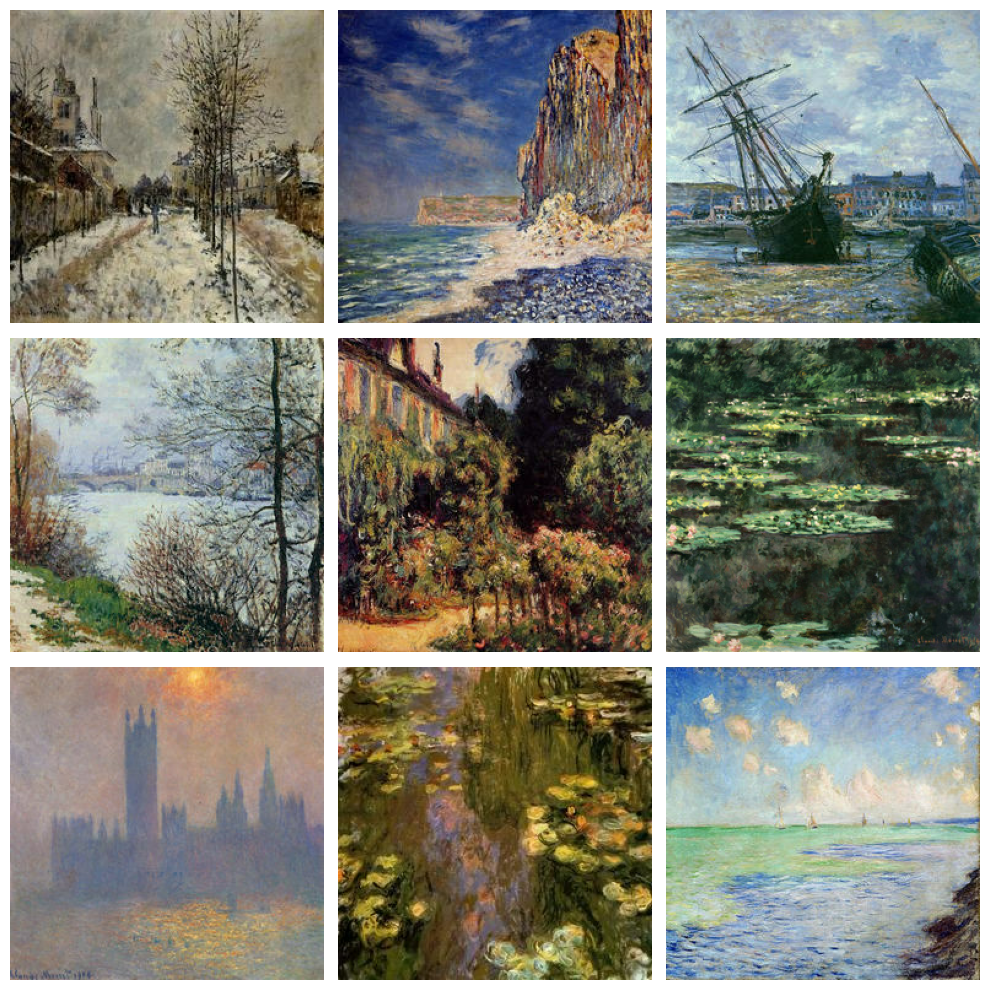

In [14]:
print('Monet Sample Images')
show_images(monet_ds)


Sample Non-Monet Images


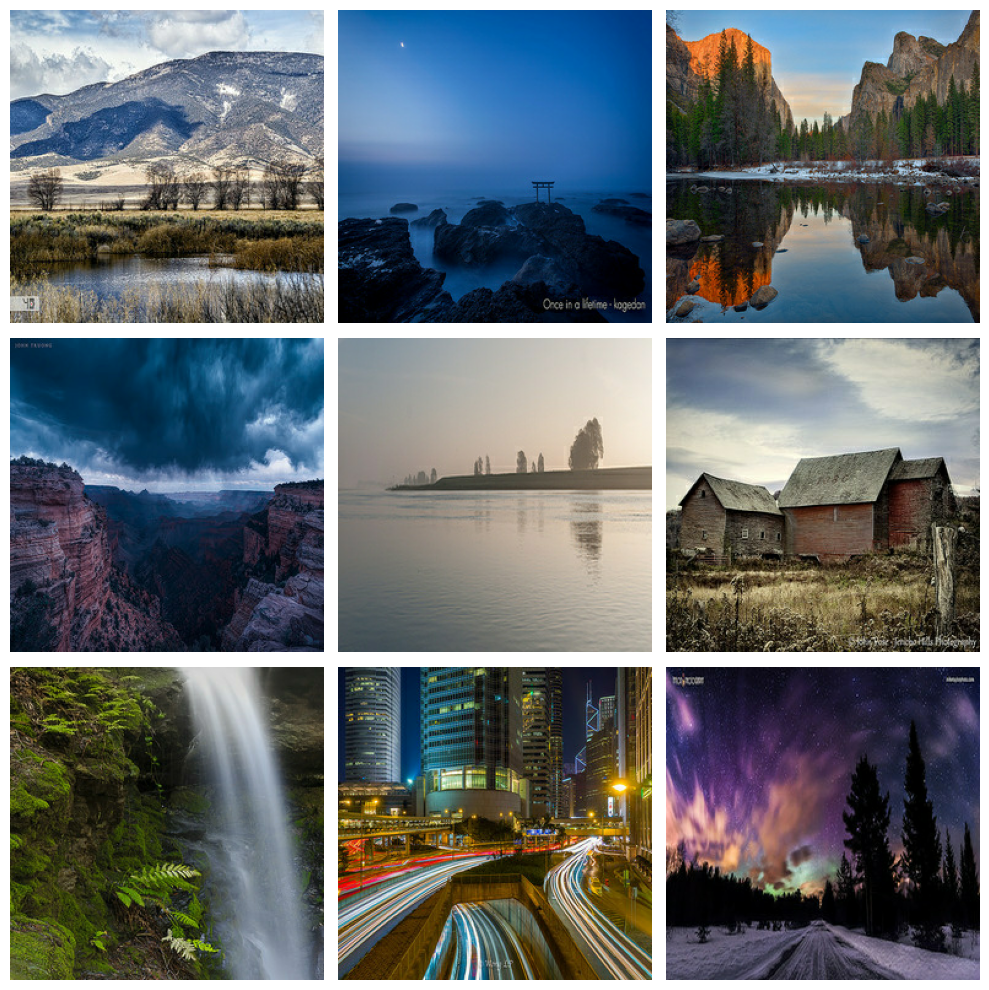

In [15]:
print("Sample Non-Monet Images")
show_images(photo_ds)

## Build the Model

To build our CycleGAN model, first we load the generators and discriminators. As the authors of the CycleGAN tutorial show us, we use the preloaded pix2pix models. These are preloaded unet architectures. Next we define the loss functions for each (binary crossentropy).

In [16]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')  # photo → Monet
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')  # Monet → photo

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)  # Monet
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)  # Photo


In [17]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 10

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA * 0.5


In [18]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


## Train the Model

Using the CycleGAN training function, we train our model.

In [19]:
@tf.function
def train_step(real_x, real_y):
    # real_x: photos, real_y: Monet paintings
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_y = generator_g(real_x, training=True)  # photo → Monet
        cycled_x = generator_f(fake_y, training=True)  # Monet → photo → photo

        fake_x = generator_f(real_y, training=True)  # Monet → photo
        cycled_y = generator_g(fake_x, training=True)  # photo → Monet → Monet

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


In [22]:
import time
EPOCHS = 25

for epoch in range(EPOCHS):
    start = time.time()
    print(f"Epoch {epoch+1}/{EPOCHS}")

    for image_x, image_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(image_x, image_y)

    print(f"Time taken for epoch {epoch+1}: {time.time()-start:.2f} sec")


Epoch 1/10
Time taken for epoch 1: 73.51 sec
Epoch 2/10
Time taken for epoch 2: 73.50 sec
Epoch 3/10
Time taken for epoch 3: 73.48 sec
Epoch 4/10
Time taken for epoch 4: 73.49 sec
Epoch 5/10
Time taken for epoch 5: 73.48 sec
Epoch 6/10
Time taken for epoch 6: 73.48 sec
Epoch 7/10
Time taken for epoch 7: 73.51 sec
Epoch 8/10
Time taken for epoch 8: 73.52 sec
Epoch 9/10
Time taken for epoch 9: 73.50 sec
Epoch 10/10
Time taken for epoch 10: 73.49 sec


In [23]:
def generate_images(model, input_image):
    prediction = model(input_image, training=False)
    plt.figure(figsize=(12, 6))

    display_list = [input_image[0], prediction[0]]
    title = ['Input Image', 'Stylized Output']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Convert from [-1, 1] to [0, 1]
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.show()


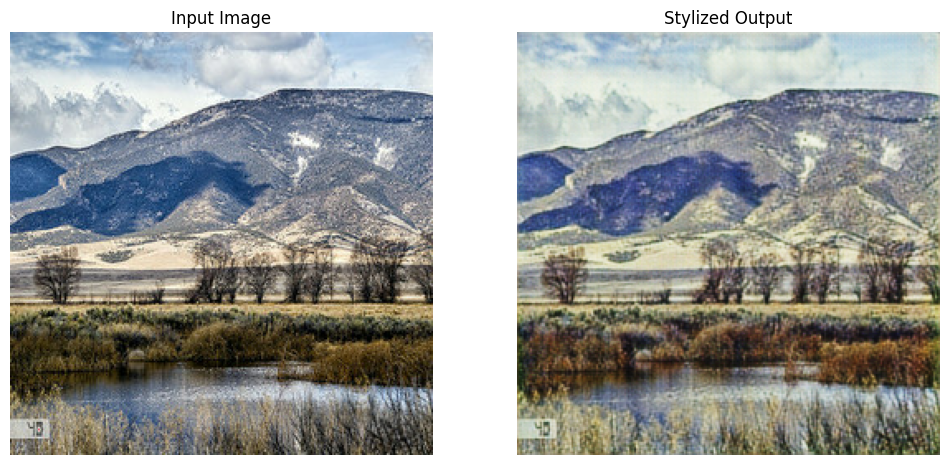

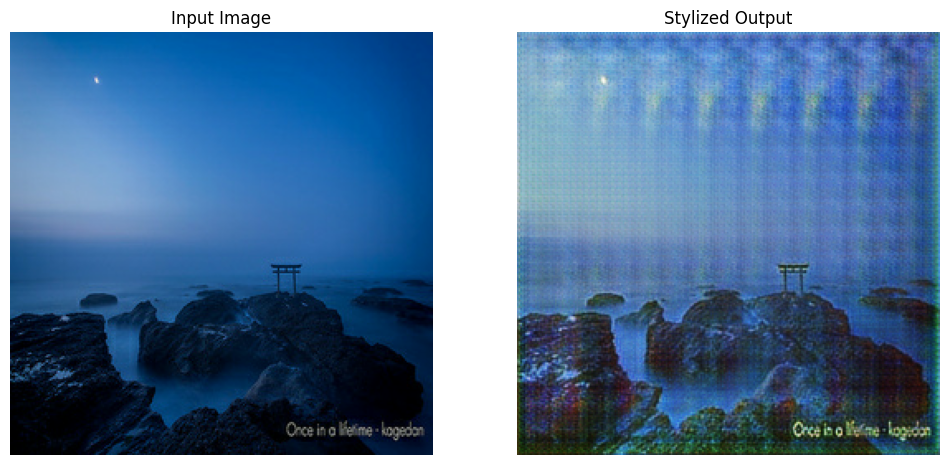

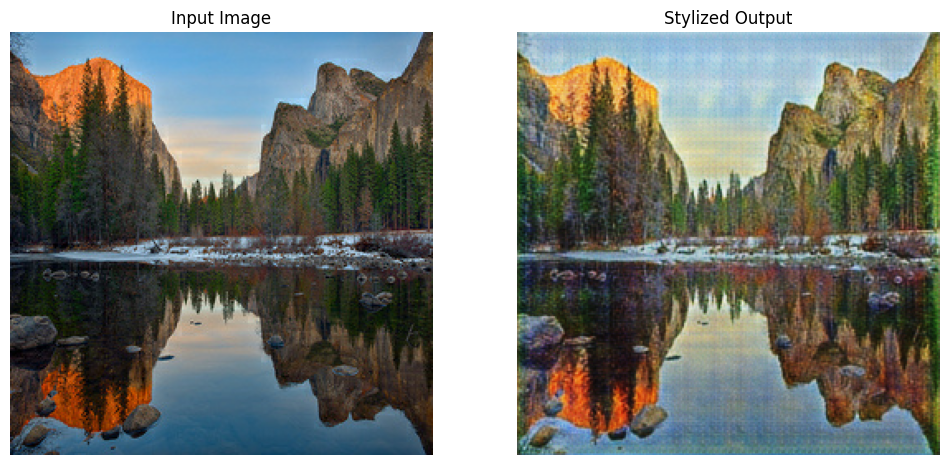

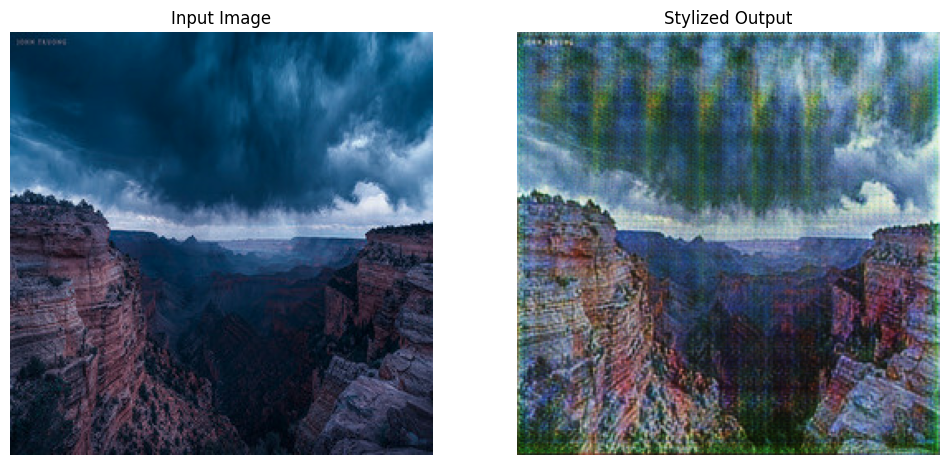

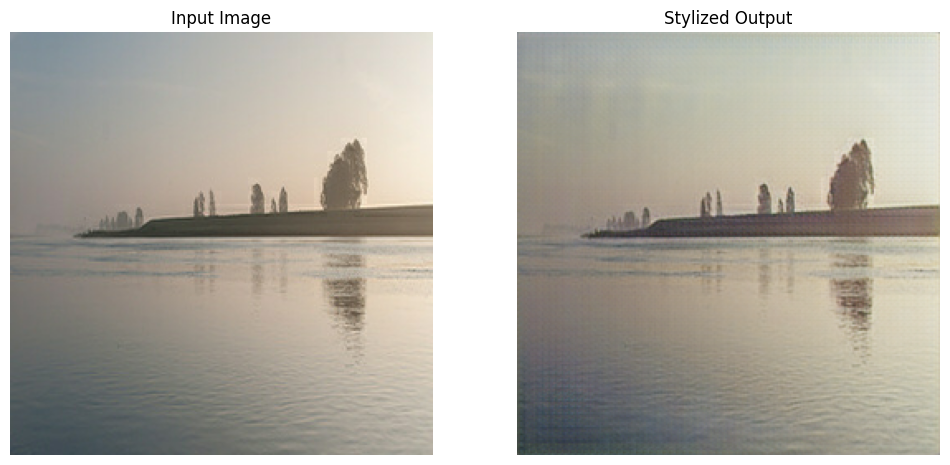

In [25]:
for image in photo_ds.take(5):
    generate_images(generator_g, image)


## Create Submission File

In [26]:
import PIL
! mkdir ../images


In [28]:
import os
import numpy as np
import PIL.Image
import shutil

# Create output directory
os.makedirs("/kaggle/working/images", exist_ok=True)

# Generate Monet-style images from photo_ds and save
i = 1
for img in photo_ds:
    prediction = generator_g(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)  # Scale back to [0, 255]
    im = PIL.Image.fromarray(prediction)
    im.save(f"/kaggle/working/images/{i}.jpg")  # Save to correct path
    i += 1

# Zip the folder for submission
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")


'/kaggle/working/images.zip'

## Next Steps

Because of time and computing contraints, I was only able to run 25 epochs of training. Even with that few number of training epochs, I was able to score a 64.54 on the Kaggle leaderboard.  However, with many more epochs, results would certainly improve. There are also other architectures that I could try, including a ResNet architecture rather than the unet used in the pix2pix model. 

## References

1. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
2. https://www.tensorflow.org/tutorials/generative/cyclegan